# H&M data deep dive

# Updates! 2022.02.17
 - Specified datatype to article_id by 'dtype={'article_id': str}' <- This setting is very important!! If you don't do this, the leading 0 will be automatically omitted and the score of the submit will be 0.
 
# Agenda
 - Intro
 - Explanation of index group, index, product type with H&M EC site.
 - Product sales seasonality
 - Classify seasonal products by GMM clustering
 - Detect products that will no longer be sold in late September 2020.
 - Classify "Expensive products" and "Cheap products" calculated from the average price of each product type.  <-- **UPDATED!**

# Chapter.1 Understand article

When we want to recommend a product to a customer in front of us, we want to know more about the product and understand the customer in order to make a quality recommendation (e.g., the customer's age, gender, family structure, area of residence, occupation, popular products for this type of customer, etc.)

If you are an experienced staff and already have a deep understanding of the products and customers, you can make recommendations with confidence, but at least I don't have deep experience and knowledge of H&M's products and customers.

Instead, let's understand our customers by analyzing their past data!
For example, if we can estimate in advance through analysis that the customer in front of us is a man in his 30s, has a newborn baby, and lives in a cold area, and we also know the products that are very popular with that type of customer, then we can be more confident in our product offering strategy!

I would like to share my analysis report in the following three parts.
 1. Understand article
 2. Understand customer
 3. Understand transaction

The purpose of this analysis is to gain a deep understanding of H&M's products, customers, and business before building a recommendation model, and to help build a strategy for designing a recommendation model. I believe that understanding data and business is not only useful to build highly accurate recommendation models, but also useful to build explainable models and very important to become a data scientist trusted by stakeholders.

The following is a data-based explanation of the important business characteristics that you should know in advance when creating a recommendation model, but I will skip explaining what has already been explained in other Notes, citing only the URL here.

This notebook contains only 1 and I will create and share 2 and 3 later.  

#### Important tips
1. sales_channel_id=1: Sales of ONLINE, 2: Sales of OFFLINE  
https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/306016

2. Data summary  
https://www.kaggle.com/remekkinas/h-m-eda-first-look-into-data

# **Please upvote :)**

In [ ]:
import pandas as pd
import plotly.express as px

# Explanation of index group, index, product type with H&M EC site
First articles are divided by index group into five categories: Ladieswear, Divided, Menswear, Baby/Children, and Sport.

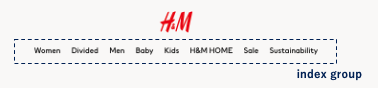

Images in this notebook are cited from H&M EC webpage here
https://www2.hm.com/en_us/index.html

The index group is further subdivided by index as follows.

|index group|index|
| -------- | -------- |
|Ladieswear  |Ladieswear  |
||Lingeries/Tights  |
||Ladies Accessories  |
|Divided  |Divided  |
|Menswear  |Menswear  |
|Baby/Children  |Baby Sizes 50-98  |
|  |Children Sizes 92-140  |
|  |Children Sizes 134-170  |
|  |Children Accessories, Swimwear  |
|Sport|Sport|


Products are categorized (almost) by product type, such as jacket, polo, etc. (! But it's not a complete 1-on-1 system.)

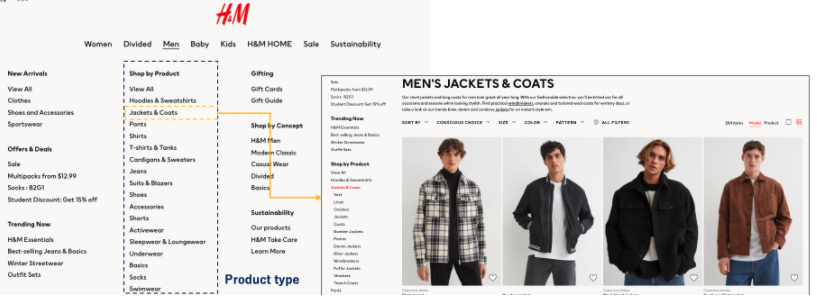


Baby/Children and Sport are not indexed by gender, but the keywords Ladies/Men/Girl/Boy are listed in the department, so you can distinguish whether the articles are for female or male.

|index|department|
| -------- | -------- |
|Baby Sizes 50-98  |Baby **Girl** Jersey Fancy  |
||Baby **Boy** Woven  |
||Newborn  |
||other  |
|Sport|**Ladies** Sport Acc|
||**Men** Sport Acc|
||Bottoms **Girls**|
||Bottoms **Boys**|
||...etc|

Divided is a street fashion product that targets women in their teens~20s.

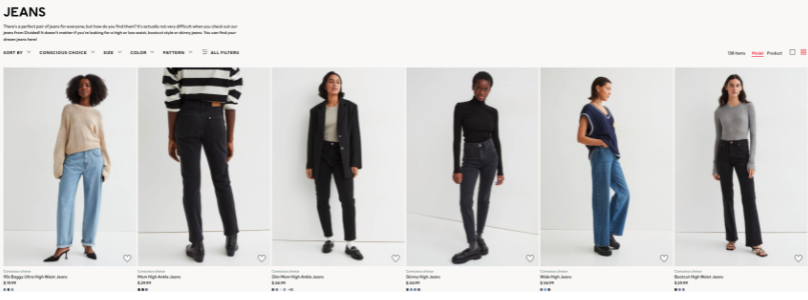

The section name contains information that is generally duplicated in other columns, but there is one important keyword: **'Mama'**. This is a product for pregnant women.

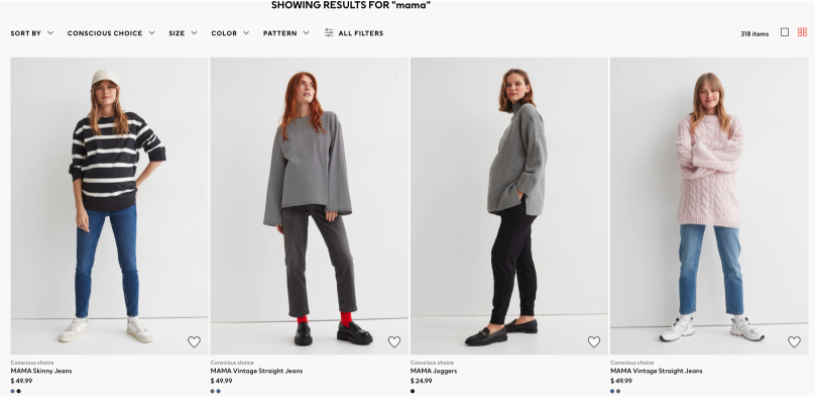

So far, by observing the index group, index, product type, and department for Baby/Children and Sport for all articles, we can find out which articles should be worn by which age group, which gender, and in which climate.

For example following article.

|index group|index|product type|
| -------- | -------- | -------- |
|Menswear  |Menswear  |Jacket|

We can imagine that the customer who purchased the product is a MALE who is feeling cold. If some of the customers are buying in the summer time, we can estimate that they live in areas where the temperature is somewhat low all year round.

Or if you have a customer who frequently buys products from Baby Sizes 50-98, you can imagine that they are a parent who recently had a child. A few months ago, they may have purchased a product from the Mama section.

By knowing about the articles, you can estimate the characteristics of the customers who are buying it, but this analysis will be discussed in a **H&M data DEEP DIVE / chap.2 Understand customer**.

The first step here is to pre-process the flagging of the articles, whether they are for men, women, or 'mama'.

In [ ]:
df_article = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv',dtype={'article_id': str})

def set_gender_flg(x):
    x['is_for_male'] = 0
    x['is_for_female'] = 0
    x['is_for_mama'] = 0
    if x['index_group_name'] in ['Ladieswear','Divided']:
        x['is_for_female'] = 1
    if x['index_group_name'] == 'Menswear':
        x['is_for_male'] = 1
    if x['index_group_name'] in ['Baby/Children','Sport']:
        if 'boy' in x['department_name'].lower() or 'men' in x['department_name'].lower():
            x['is_for_male'] = 1
        if 'girl' in x['department_name'].lower() or 'ladies' in x['department_name'].lower():
            x['is_for_female'] = 1
    if x['section_name'] == 'Mama':
        x['is_for_mama'] = 1
    return x

df_article = df_article.apply(set_gender_flg, axis=1)
df_article.head()

# Product sales seasonality
There are also articles that sell well and articles that do not sell well depending on the season. Let's take a look at some of these trends. articles that are unlikely to sell well in late September are unlikely to be candidates for this recommendation, so we will flag these types of products.

By the way, I personally know from experience that Jackets sell well in late September.

Check the trend of sales by monthly aggregating by products classified by **index group**, **index**, and **product type**.

In [ ]:
df_article['idxgrp_idx_prdtyp'] = df_article['index_group_name'] + '_' + df_article['index_name'] + '_' + df_article['product_type_name']

df_trans = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',dtype={'article_id': str})
df_trans = df_trans.sample(frac=0.1) # downsampling due to memory limits
df_trans['t_dat'] = pd.to_datetime(df_trans['t_dat'])
df_trans['YYYY_MM'] = df_trans['t_dat'].dt.year.astype(str) + '_' + df_trans['t_dat'].dt.month.astype(str)
df_trans['year'] = df_trans['t_dat'].dt.year
df_trans['month'] = df_trans['t_dat'].dt.month
df = pd.merge(df_trans, df_article, on='article_id', how='left')
del df_trans, df_article

dfgrp1 = df.groupby(['idxgrp_idx_prdtyp'])[['price']].sum().reset_index()
dfgrp2 = df.groupby(['idxgrp_idx_prdtyp', 'year', 'month'])[['price']].sum().reset_index()
dfgrp2 = pd.merge(dfgrp2, dfgrp1, on='idxgrp_idx_prdtyp', how='left')
dfgrp2['monthsales/ttl-sales'] = dfgrp2['price_x'] / dfgrp2['price_y'] * 100
dfgrp2['ym_date'] = dfgrp2['year'].astype(str) + '-' + dfgrp2['month'].astype(str) + '-1'
dfgrp2['ym_date'] = pd.to_datetime(dfgrp2['ym_date'])
dfgrp2 = pd.pivot_table(dfgrp2, index='ym_date', columns='idxgrp_idx_prdtyp', values='monthsales/ttl-sales').reset_index().fillna(0)
display(dfgrp2.head())

fig = px.line(dfgrp2, x='ym_date', y=['Ladieswear_Ladieswear_Jacket',
                                      'Divided_Divided_Jacket',
                                      'Menswear_Menswear_Jacket',
                                      'Ladieswear_Ladieswear_Sweater',
                                      'Divided_Divided_Sweater',
                                      'Menswear_Menswear_Sweater'], title="MothlySales / TTL sales")
fig.show()

The data confirms the fact that Jacket sells well in late September.
Therefore, we may be able to predict that the articles that have a **negative correlation** with Ladieswear_Ladieswear_Jacket sales are the products that do **NOT** sell well in late September.
We will test this hypothesis by calculating the correlation with Ladieswear_Ladieswear_Jacket and selecting some of the articles with the strongest negative correlation.

In [ ]:
display(dfgrp2.corr()[['Ladieswear_Ladieswear_Jacket']].reset_index().sort_values(by='Ladieswear_Ladieswear_Jacket').head(10))

fig = px.line(dfgrp2, x='ym_date', y=['Ladieswear_Ladieswear_Shorts',
                                      'Divided_Divided_Shorts',
                                      'Menswear_Menswear_Shorts',
                                      'Ladieswear_Lingeries/Tights_Swimwear bottom',
                                      'Ladieswear_Lingeries/Tights_Swimsuit',
                                      'Menswear_Menswear_Swimwear bottom'], title="MothlySales / TTL sales")
fig.show()

Apparently, it worked; few customers buy shorts and swimwear in late September (maybe H&M's inventory strategy is one of the factor).
From this result, we can expect that the correlation coefficient with the Ladieswear_Ladieswear_Jacket products can be used as a quantitative indicator (**autumn_sales_indicator**) of the sales potential of the products in late September.

# Classify seasonal products by GMM clustering
We found that there is a strong seasonality in sales for each product type. On the other hand, there are some products whose demand does not change significantly throughout the year (e.g. accessories). If the data is clustered properly, typing when each product type should be sold in which season will be useful for building recommendation models later on.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feat_cols = [col for col in dfgrp2.columns if col != 'ym_date']

df_pca = StandardScaler().fit_transform(dfgrp2[feat_cols])
model_pca = PCA(n_components=5)
model_pca.fit(df_pca)
feature = model_pca.transform(df_pca)

df_eigen = model_pca.components_.T
df_eigen = pd.DataFrame(df_eigen,
                        index=None,
                        columns=['PC1','PC2','PC3','PC4','PC5'])
df_eigen['idxgrp_idx_prdtyp'] = feat_cols
df_eigen = pd.merge(
    df_eigen,
    dfgrp2.corr()[['Ladieswear_Ladieswear_Jacket']].reset_index().rename(columns={'Ladieswear_Ladieswear_Jacket': 'autumn_sales_indicator'}),
    on='idxgrp_idx_prdtyp',
    how='left'
)
px.scatter(df_eigen, x='PC1', y='PC2', hover_name='idxgrp_idx_prdtyp', color='autumn_sales_indicator')

Dimensionality reduction is performed by principal component analysis, and the principal component scores for each product type are visualized by scatter plots.
The autumn_sales_indicator is mostly explained by PC1, and we can see that products such as Jacket and Sweater are located in the lower right corner, while Shorts and Swimwear are located in the upper left corner.

Performed Gaussian mixture for clustering.

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(df_eigen[['PC1','PC2','PC3']])
df_eigen['product_seasonal_type'] = gmm.predict(df_eigen[['PC1','PC2','PC3']])
df_eigen['prob_cluster1'] = gmm.predict_proba(df_eigen[['PC1','PC2','PC3']])[:,0]
df_eigen['prob_cluster2'] = gmm.predict_proba(df_eigen[['PC1','PC2','PC3']])[:,1]
df_eigen['prob_cluster3'] = gmm.predict_proba(df_eigen[['PC1','PC2','PC3']])[:,2]
df_eigen['prob_cluster4'] = gmm.predict_proba(df_eigen[['PC1','PC2','PC3']])[:,3]
px.scatter(df_eigen, x='PC1', y='PC2', hover_name='idxgrp_idx_prdtyp', color='product_seasonal_type')

Jackets and Sweaters were classified as class 1 and 2, while Shorts and others were classified as class 3. There is room to optimize the appropriate parameters as we see the accuracy of recommendation model.
For now, I will check the seasonality of sales for some of the products identified as class 0.

In [ ]:
fig = px.line(dfgrp2, x='ym_date', y=['Ladieswear_Ladies Accessories_Hair string',
                                      'Divided_Divided_Belt',
                                      'Ladieswear_Lingeries/Tights_Unknown'], title="Sales transition")
fig.show()

In [ ]:
df = pd.merge(
    df,
    df_eigen[['idxgrp_idx_prdtyp','autumn_sales_indicator', 'product_seasonal_type', 'prob_cluster1', 'prob_cluster2', 'prob_cluster3', 'prob_cluster4']],
    on='idxgrp_idx_prdtyp',
    how='left'
)
del dfgrp1, dfgrp2
df.head()

# Detect products that will no longer be sold in late September 2020
Next, we will flag articles that we believe are no longer available in 2020.9. Here, while looking at the article_id, if the sales before 2019.9 account for more than 95% of the sales of the article in question, we will assume that the article is no longer sold by the end of 2020.9, or that it is very rare to be sold, and exclude it from this recommendation. In this case, we will exclude them.

In [ ]:
dfagg1 = df.groupby(['article_id'])[['price']].sum().reset_index().rename(columns={'price': 'article_ttl_sales'})
dfagg2 = df[df['t_dat'] < '2019-09-01'].groupby(['article_id'])[['price']].sum().reset_index().rename(columns={'price': 'before_201909_article_ttl_sales'})
dfagg3 = df[df['t_dat'] > '2019-09-01'].groupby(['article_id'])[['price']].sum().reset_index().rename(columns={'price': 'after_201909_article_ttl_sales'})

dfagg1 = pd.merge(dfagg1, dfagg2, on='article_id')
dfagg1 = pd.merge(dfagg1, dfagg3, on='article_id')
dfagg1['before_201909_article_ttl_sales_ratio'] = dfagg1['before_201909_article_ttl_sales'] / dfagg1['article_ttl_sales'] * 100
dfagg1['not_for_sales_flg'] = (dfagg1['before_201909_article_ttl_sales_ratio'] > 95).astype(int)

display(dfagg1.sort_values(by='before_201909_article_ttl_sales_ratio', ascending=False).head(5))
dftmp = df[df['article_id']=='0698276001'].sort_values(by='t_dat')
fig = px.bar(dftmp, x='t_dat', y='price', title="Not for sales article example")
fig.show()

You can see that the products in article id=698276001 will not be sold much anymore in 2020.  
Next, merge these data for use in our recommendation model.

In [ ]:
df = pd.merge(
    df,
    dfagg1[['article_id','before_201909_article_ttl_sales_ratio', 'not_for_sales_flg']],
    on='article_id',
    how='left'
)
df.head()

# Classify "Expensive products" and "Cheap products" calculated from the average price of each product type
Some customers prefer higher priced products of the same type, while others prefer cheaper products.
If we want to detect this from the purchase history, we need to know the average price of that product category.  
Since 'high' and 'low' prices are determined relatively, we will tabulate in advance what the average price is for each product type.



In [ ]:
dfagg = df.groupby(['idxgrp_idx_prdtyp'])[['price']].mean().reset_index().rename(columns={'price': 'idxgrp_idx_prdtyp_mean_price'})
df = pd.merge(
    df,
    dfagg[['idxgrp_idx_prdtyp','idxgrp_idx_prdtyp_mean_price']],
    on='idxgrp_idx_prdtyp',
    how='left'
)
df.head()

## Conclusion
 - I found out that by classifying products by index group, index, product type, etc., we can understand the characteristics of a product, such as whether it is for men, women, infants, or pregnant women. I introduced a program to set flags for them.　This can be a useful piece of information when understanding the customer.
 - I found that sales of some products are more seasonal than others, especially jackets. By correlating the sales of jackets, we can quantitatively identify the products that sell well in the fall and those that do not. I introduced 'autumn_sales_indicator' for this.
 - Apparel is a product that goes out of fashion rapidly. I have introduced a program that flags products that will no longer be available by the end of September 2020. I think these can be effectively used to determine what products to recommend in the end.
 
If you find this notebook useful, please give it an upvote :)
